In [2]:
import numpy as np
from matplotlib import pyplot as plt
import csb
import pandas as pd 
from Bio import SeqIO
import pandas as pd
from colour import Color
import pickle
import h5py
import dendropy
from Bio import AlignIO , SeqIO



In [3]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
alnh5 = alnfile+'.h5'

datapath = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/'

In [4]:
#use the dataframe with orf predictions for one genome
annotation = pd.read_csv(datapath + 'gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.alntestgeno_wclusters.csv')
print(annotation)

    Unnamed: 0    qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0           13  testgeno  YP_009725298.1  29903   638     806   2719       2   
1            3  testgeno  YP_009725299.1  29903  1945    2720   8554       2   
2           17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
3           21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
4           25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
5           41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
6           32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
7           37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
8           34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
9           12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
10          15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
11          16  testgeno  YP_009725309.1

In [5]:

#select genomes
#model translated prots
print(annotation.prots)
#write out the proteomes
geno = 'hCoV-19'

def write_fasta( genos , genodf , path='COVIDpoteomes.fasta'  ):
    with open( path + geno , 'w' ) as fastout:
        for geno in genos:
            sub = genodf[ genodf.genome.is_in( geno ) ]
            for i,r in sub.itterrows():
                fastout.write( '>'+ i + '\n'+ r.prot + '\n' )

def write_split_fasta( genodf , path= None  ):
    #make a folder and split up the fasta for use with hhblits
    paths = []
    for i,r in genodf.iterrows():
        name = r.sseqid + geno 
        #name = i.replace('>','').replace('/','_')
        with open( path + r.sseqid + '.fasta', 'w' ) as fastout:
            fastout.write( '>'+ r.sseqid + '\n'+ r.prots + '\n' )
        paths.append(path + r.sseqid +'.fasta')
    return paths

paths = write_split_fasta( annotation , path = datapath )
print(paths)

0     AYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKR...
1     APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...
2     KIVNNWLKQLIKVTLVFLFVAAIFYLITPVHVMSKHTDFSSEIIGY...
3     SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...
4     SAVKRTIKGTHHWLLLTILTSLLVLVQSTQWSLFFFLYENAFLPFA...
5     SKMSDVKCTSVVLLSVLQQLRVESSSKLWAQCVQLHNDILLAKDTT...
6     AIASEFSSLPSYAAFATAQEAYEQAVANGDSEVVLKKLKKSLNVAK...
7     NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...
8     AGNATEVPANSTVLSFCAFAVDAAKAYKDYLASGGQPITNCVKMLC...
9     FKRVCGVSAARLTPCGTGTSTDVVYRAFDIYNDKVAGFAKFLKTNC...
10    AVGACVLCNSQTSLRCGACIRRPFLCCKCCYDHVISTSHKLVLSVN...
11    AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...
12    SLENVAFNVVNKGHFDGQQGEVPVSIINNTVYTKVDGVDVELFENK...
13    SSQAWQPGVAMPNLYKMQRMLLEKCDLQNYGDSATLPKGIMMNVAK...
14    SSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLP...
15    MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
16    MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
17    MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANR

In [6]:
import subprocess
import shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [7]:
import glob
prots = paths
print(prots)

['/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725299.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725300.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725301.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725302.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725303.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725304.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725305.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725306.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725307.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020

In [8]:
#run hhblits
results = {}
for prot in prots:
    p, outfiles = runHHblits( prot , prot+'.hhr' , 'hhblits', outdir = '' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , ohhm = True,  iterations = 1 , ncores = 8 , )
    results[prot]=outfiles

['/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta.hhr', 'hhblits', '', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i /home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta -o /home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta.hhr.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m /home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725298.1.fasta.hhr.a3m
['/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725299.1.fasta', '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/YP_009725299.1.fasta.hhr', 'hhblits', '', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -

KeyboardInterrupt: 

In [ ]:
#parse results
from csb.bio.io.hhpred import HHOutputParser
predDfs  = {}
topk = 2
models = []
predictions = glob.glob( datapath+'*.hhr')
for pred in predictions:
    results = HHOutputParser(alignments=False).parse_file(pred)
    newhits = {}
    hitlist=[]
    for hit in results:
        hitlist.append(hit.id)
        newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score   , 'start':hit.start , 'stop':hit.end }}  )

    hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
    hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
    hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])
    print(hhdf.head())
    predDfs[pred] = hhdf
    models+=list(hhdf.model)[0:topk]
print(models)
    

In [ ]:
from skbio import TabularMSA, Protein
from Bio.Alphabet.IUPAC import protein as alpha
alpha = list(alpha.letters)+['-'] 
print(alpha)


In [ ]:
#now we have some long high quality hits to some chains
#get templates
import wget
import glob

dl_url = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( '../templates/*.pdb' )
print(already)
for m in models:
    print(m)
    structfile = '../templates/'+m.upper()+'.pdb'
    structs[m]= structfile
    if structfile not in already:
        wget.download(url = dl_url + m +'.pdb' , out =structfile)

In [ ]:
from Bio.PDB import *
#find ca string for each strucutre
#make sure you grab the right chain
from Bio import Alphabet
parser = PDBParser()
from Bio.SeqUtils import seq1
letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3} 
print(converter)

In [ ]:
models = {}
ali_input = {}
builder = Polypeptide.PPBuilder()
#slice structures in hhr

io=PDBIO()
sliceprots = False


# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['../modellercif/']

print('resolving discontinuities')
class resselect(Select):
    def __init__(self, reslist):
        self.reslist=reslist
    
    def accept_residue(self ,residue ):
        if residue in self.reslist:
            return 1
        else:
            return 0      
for df in predDfs:
    print(predDfs[df])
    count = 0
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count+=1
            code = row.model
            if code in structs:
                print(code)

                structure = parser.get_structure(code,structs[code])
                io.set_structure(structure)

                for chain in structure.get_chains():
                    if chain.id == row.chain:
                        #trim the structures to hhblits detected regions
                        if sliceprots == True:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=row.start-1, end=row.stop , filename='./modellercif/'+row.model+'.pdb' )
                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #subchains = [ c for c in structure.get_chains()]
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)

                        else:
                            #Dice.extract(structure=structure , chain_id=chain.id , start=0, end=len(chain), filename='./modellercif/'+row.model+'.pdb' )

                            #sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                            #sub_structure = structure
                            peptides  = [p for p in  builder.build_peptides(chain)]
                            peptidelen  = [len(p) for p in  builder.build_peptides(chain)]
                            print(peptidelen)
                            #pp = peptides[0]

                        for i,pp in enumerate( peptides):
                            #break all subchains into files
                            if peptidelen[i] > 75:
                                io.save('../modellercif/'+row.model+'_'+str(i) +'.pdb', resselect(pp))
                                seq = str(pp.get_sequence())
                                print(seq)
                                models[row.model+'_'+str(i)]={'mdl': '../modellercif/'+row.model+'_'+str(i) +'.pdb' , 'chain':chain.id }
                            #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  } 
                        #mdl = model(env, file='./modellercif/'+row.model+'.pdb', model_segment=('FIRST:'+chain.id, 'LAST:'+chain.id))
                        #chains = mdl.make_chains(file='./modellercif/'+row.model+'.pdb')

                        #for i,pp in enumerate(peptides):
                        #    if i > 0:
                        #        seq+='-'
                        #    seq += str(pp.get_sequence())
                        #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  }     
                        # grab all sequences from the query input

print('DONE')

In [ ]:
from modeller import *
import modeller.salign
log.none()
env = environ()
env.io.atom_files_directory = ['../modellercif/']
knowns = {}
structalns = {}

#aln = alignment(env, file='align2d_in.ali', align_codes='all' )
print(models)
for df in predDfs:
    print(predDfs[df])
    count = 0
    knowns[df]=[]
    for i,row in predDfs[df].iterrows():
        if count < topk:
            count +=1
            model_list = list(predDfs[df].model)[0:topk]
            aln = alignment(env)
            
            for m in models:
                if m.split('_')[0] in model_list:
                    print(m)
                    mdl = model(env, file=m, model_segment=('FIRST:'+models[m]['chain'], 'LAST:'+models[m]['chain']))
                    aln.append_model(mdl, atom_files=m, align_codes= m)
                    knowns[df].append(m)
            print(aln)
    try:
        weights, write_fit, whole = (1., 0., 0., 0., 1., 0.), False, True
        #((1., 0.5, 1., 1., 1., 0.), False, True),
        #((1., 1., 1., 1., 1., 0.), True, False)):
        aln.salign(rms_cutoff=3.5, normalize_pp_scores=False,
           rr_file='$(LIB)/as1.sim.mat', overhang=30,
           gap_penalties_1d=(-450, -50),
           gap_penalties_3d=(0, 3), gap_gap_score=0, gap_residue_score=0,
           dendrogram_file='1is3A.tree',
           alignment_type='tree',
           feature_weights=weights, # For a multiple sequence alignment only
           improve_alignment=True, fit=True, write_fit=write_fit,
           write_whole_pdb=whole, output='ALIGNMENT QUALITY')
        #aln.write(file='1is3A-it.pap', alignment_format='PAP')
        structalns[df] = df+'.ali'
        aln.write(file= structalns[df], alignment_format='PIR')
    except:
        print('alnerr')
    print('DONE')
print(knowns)

In [ ]:
blockct = 0
print('making sequence pir')

from Bio import SeqIO
print(predDfs.keys())
finalaln = {}
alidfs = {}
#write out each seq as a gapless pir
for df in predDfs:
    fasta = df.replace('.hhr', '')
    print(fasta)
    ali_input ={}
    for seq in SeqIO.parse(fasta , 'fasta'):
        ali_input[seq.id] = { 'chain': '', 'seq': str(seq.seq) , 'start':1 , 'stop':len(seq.seq)  } 
    alidf = pd.DataFrame.from_dict( ali_input , orient = 'index')
    print(alidf.head())
    
    
    alidfs[df]=alidf
    
    
    with open( fasta+'.ali' , 'w') as alnout:
        for idx,row in alidf.iterrows():
            print(row)
            if len(row.chain ) > 0:
                pass
            #    line2 = 'structureX:'+idx+':'+str(row.start)+' :'+row.chain + ':' + str( row.stop  )  + ':::::'+'\n'
            else:
                blockct+=1
                print(idx)
                line1 = '>P1;'+idx.replace('/','_') +'\n'
                line2 = 'sequence:'+idx+':1 : :'+str( len(row.seq) )  + ':::::' +'\n' 
                line3 = row.seq +'*\n'
                #print(  line1 + line2 + line3)
                alnout.write( line1 + line2 + line3)

    print('aln struct block to seq block ')   
    #structure sensitive aln

    aln = alignment(env, file=fasta+'.ali' , align_codes='all' )
    try:
        aln.append(file=structalns[df], align_codes='all')
        aln.salign(
                       align_block= blockct,
                       gap_penalties_1d=(-10, 0),
                       gap_penalties_2d=(3.5, 3.5, 3.5, 0.2, 4.0, 6.5, 2.0, 0.0, 0.0),
                    fit = True
                       # d.p. score matrix
                       #output_weights_file='salign.mtx'
                       )
        """aln.write(file='align2d.pap', alignment_format='PAP',
                  alignment_features='INDICES HELIX BETA STRAIGHTNESS ' + \
                                     'ACCESSIBILITY CONSERVATION')
        """
        
        #output aln
        finalaln[df] = df+'final.ali'
        aln.write(file=finalaln[df], alignment_format='PIR')
        print('DONE')
    except:
        print('alnerr')

In [ ]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['../modellercif/', '../']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    print(finalaln[df])
    for seq in alidf.index:
        a = automodel(env,
                      alnfile  =  finalaln[df] ,     # alignment filename
                      knowns   =  knowns[df] ,              # codes of the templates
                      sequence =  seq.replace('/','_')   )
        # code of the target
        
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 1
        a.make()                            # do the actual comparative modeling
print('DONE')

In [ ]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['../modellercif/']

for df in finalaln:
    alidf = alidfs[df]
    print(alidf)
    
    first   =  knowns[df][0].split('_')[0]
    
    firststruct = [ s for s in knowns[df] if first in s]
    
    print(finalaln[df])
    for seq in alidf.index: 
        a = automodel(env,
                      alnfile  = finalaln[df],     # alignment filename
                      knowns   =  firststruct ,              # codes of the templates
                      sequence =   seq.replace('/','_')  )              # code of the target
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
        a.repeat_optimization = 2
        a.make()                            # do the actual comparative modeling

print('DONE')

In [9]:
import glob

models = glob.glob('Y*pdb')

print(models)

['YP_009724393.1.B99990001.pdb', 'YP_009725306.1.B99990001.pdb', 'YP_009725307.1.B99990001.pdb', 'YP_009725311.1.B99990001.pdb', 'YP_009725308.1.B99990001.pdb', 'YP_009724395.1.B99990001.pdb', 'YP_009725302.1.B99990001.pdb', 'YP_009725298.1.B99990001.pdb', 'YP_009725305.1.B99990001.pdb', 'YP_009725301.1.B99990001.pdb', 'YP_009725309.1.B99990001.pdb', 'YP_009725300.1.B99990001.pdb', 'YP_009724397.2.B99990001.pdb', 'YP_009725299.1.B99990001.pdb', 'YP_009725304.1.B99990001.pdb', 'YP_009724390.1.B99990001.pdb', 'YP_009724394.1.B99990001.pdb', 'YP_009725318.1.B99990001.pdb', 'YP_009725310.1.B99990001.pdb', 'YP_009725303.1.B99990001.pdb', 'YP_009724396.1.B99990001.pdb']


/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


YP_009724393.1.B99990001.pdb


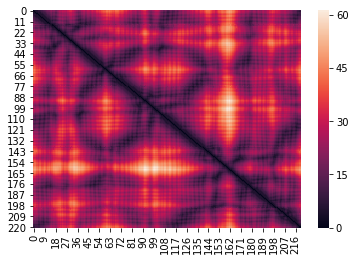

YP_009725306.1.B99990001.pdb


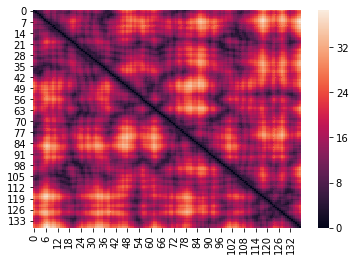

YP_009725307.1.B99990001.pdb


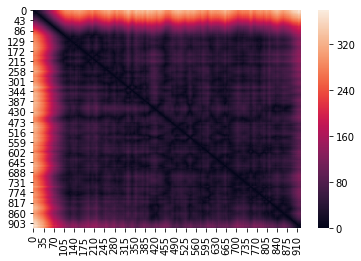

YP_009725311.1.B99990001.pdb


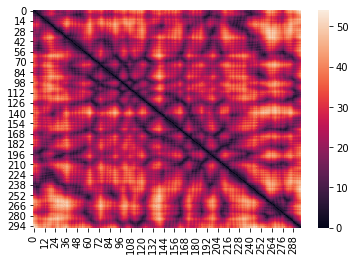

YP_009725308.1.B99990001.pdb


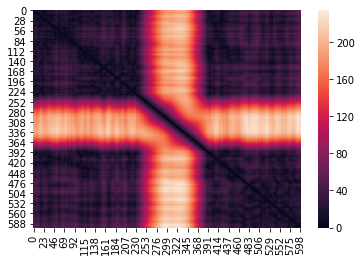

YP_009724395.1.B99990001.pdb


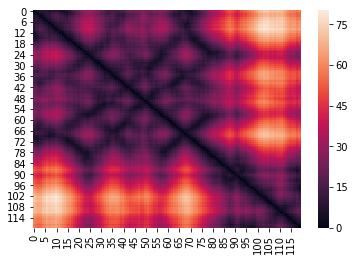

YP_009725302.1.B99990001.pdb


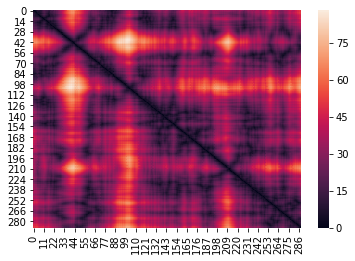

YP_009725298.1.B99990001.pdb


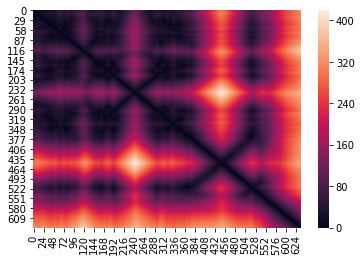

YP_009725305.1.B99990001.pdb


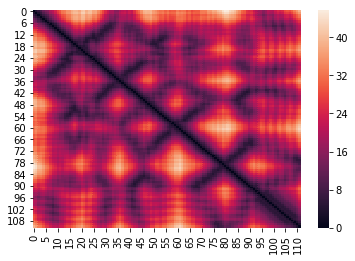

YP_009725301.1.B99990001.pdb


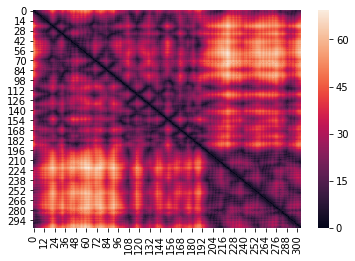

YP_009725309.1.B99990001.pdb


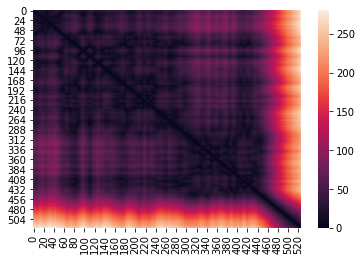

YP_009725300.1.B99990001.pdb


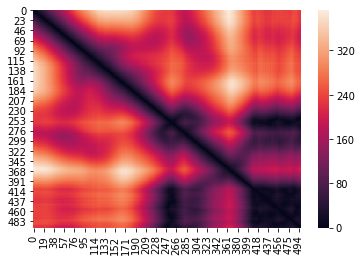

YP_009724397.2.B99990001.pdb


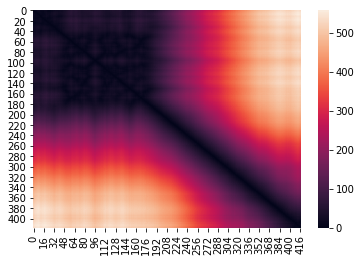

YP_009725299.1.B99990001.pdb


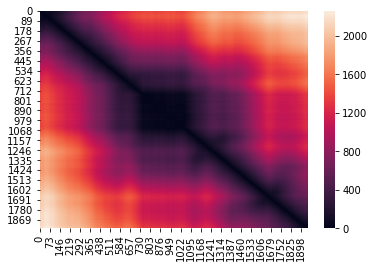

YP_009725304.1.B99990001.pdb


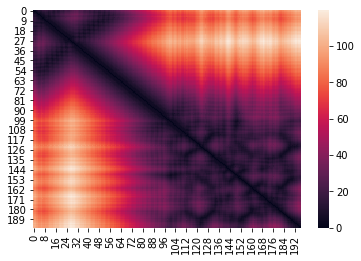

YP_009724390.1.B99990001.pdb


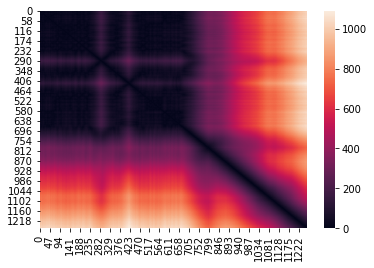

YP_009724394.1.B99990001.pdb


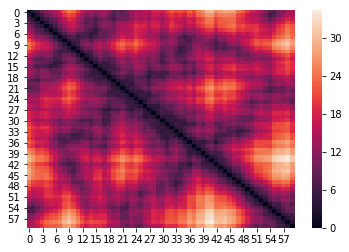

YP_009725318.1.B99990001.pdb


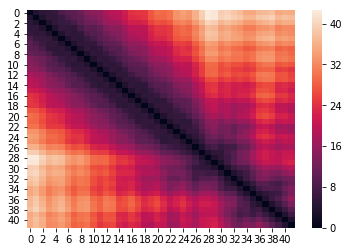

YP_009725310.1.B99990001.pdb


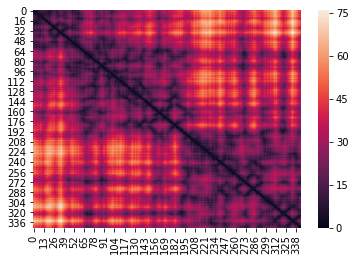

YP_009725303.1.B99990001.pdb


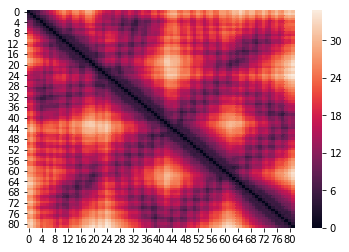

YP_009724396.1.B99990001.pdb


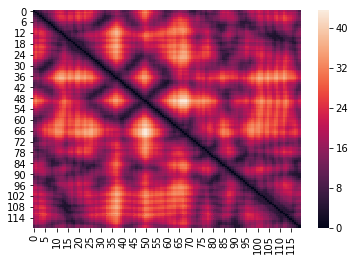

In [10]:
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser()

import seaborn as sns
for m in models:
    print(m)
    structure = parser.get_structure("test", m)
    model = structure[0]
    for chain in model.get_chains():
        distmat = np.array([ [ np.linalg.norm( r1["CA"].get_coord() - r2["CA"].get_coord() ) if i < j else 0 for i,r1 in enumerate(chain)] for j,r2 in enumerate(chain)] )   
        distmat+=distmat.T
        sns.heatmap( distmat )
        plt.show()
#make distmats for structures


In [17]:
import pandas as pd
import pickle
with open( alnfile + 'annothack.pkl' , 'rb') as annotin:
    cannotation = pickle.loads(annotin.read())

#cannotation = pd.read_csv('./gisaid/hCoV-19_USA_MA-MGH-00701_2020_EPI ISL 460358_2020-04-06_wclusters.csv')

print(cannotation)

#all clusters 


      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065

YP_009724393.1.B99990001.pdb
<class 'dict'>
{35: [17], 49: [103], 50: [15, 19, 146], 52: [20, 87], 53: [27, 81, 98, 124], 59: [95]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  50 100  35
 100  50  52 100 100 100 100 100 100  53 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  53 100 100 100 100 100  52 100 100
 100 100 100 100 100  59 100 100  53 100 100 100 100  49 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  53 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100  50 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 

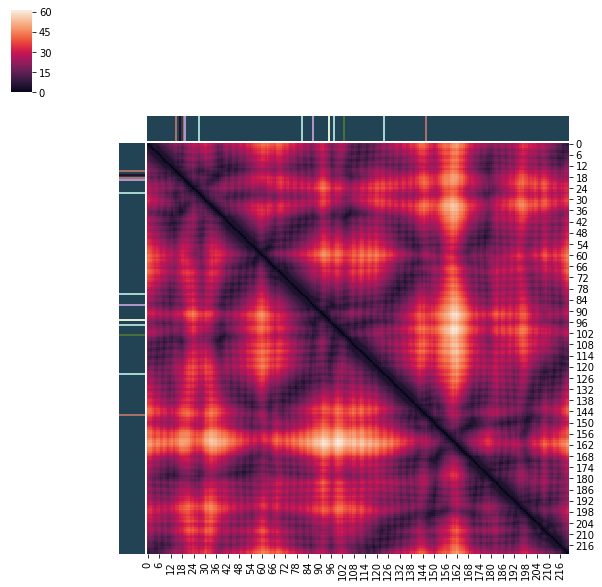

YP_009725306.1.B99990001.pdb
<class 'dict'>
{58: [47]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100  58 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100]


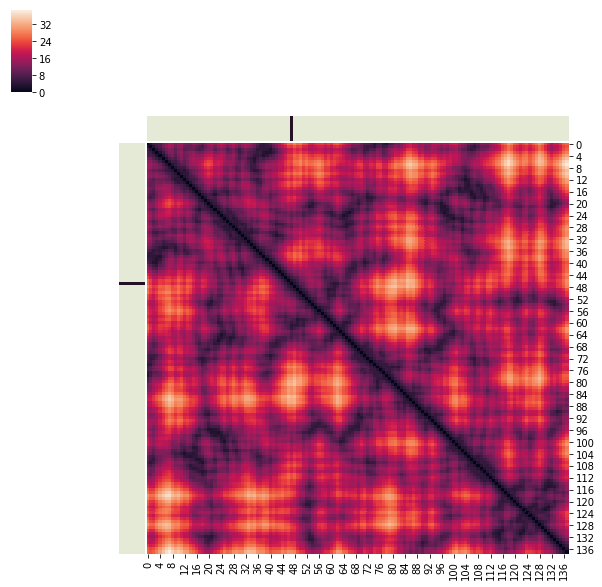

YP_009725307.1.B99990001.pdb
<class 'dict'>
{35: [649], 49: [18, 381, 425, 587], 50: [45], 52: [516], 58: [214, 325, 910]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  49 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  50 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  58 100
 

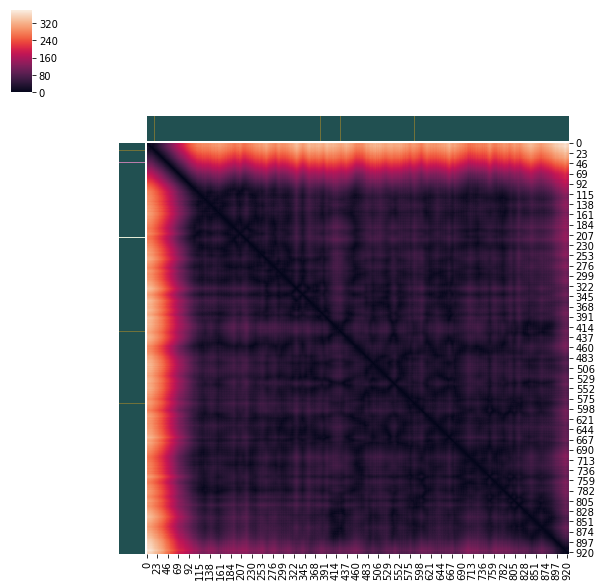

YP_009725311.1.B99990001.pdb
<class 'dict'>
{35: [90], 52: [164, 225], 53: [258, 278], 58: [121], 95: [228, 229]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  35 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100  58 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100  52 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 1

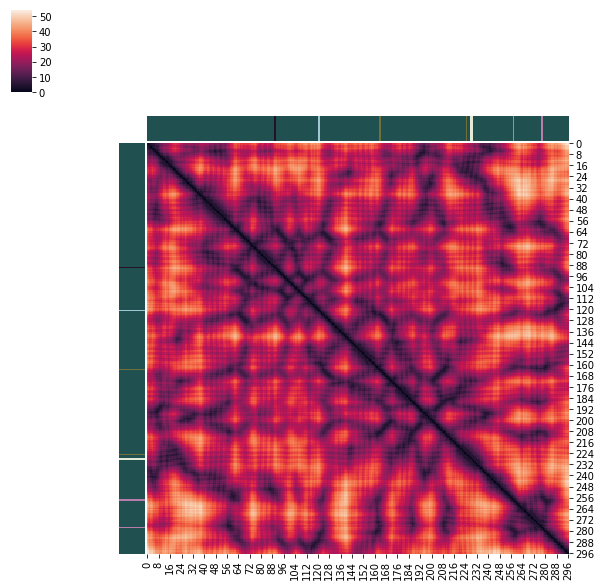

YP_009725308.1.B99990001.pdb
<class 'dict'>
{50: [57], 52: [84, 216], 53: [118, 121, 290, 358, 412], 59: [90, 266, 300, 402]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100  50 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100  52 100 100 100 100 100
  59 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100  53 100 100  53 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 10

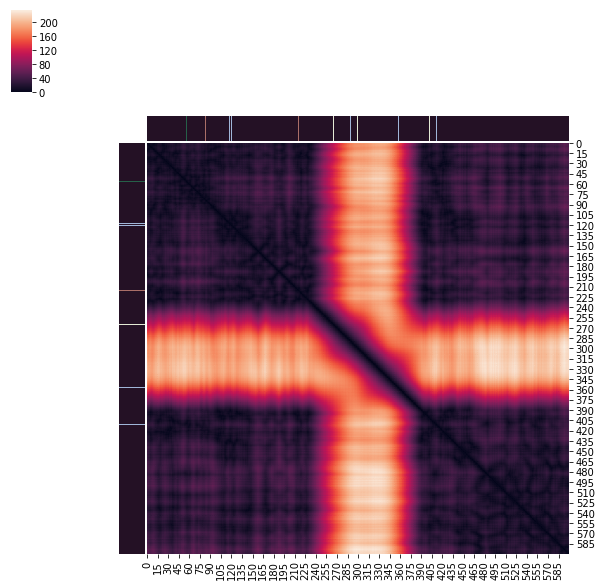

YP_009724395.1.B99990001.pdb
YP_009725302.1.B99990001.pdb
<class 'dict'>
{35: [149], 52: [172], 53: [88, 157], 58: [216], 59: [263]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  53 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100  35 100 100 100 100 100 100 100  53 100 100 100 100
 100 100 100 100 100 100 100 100 100 100  52 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100

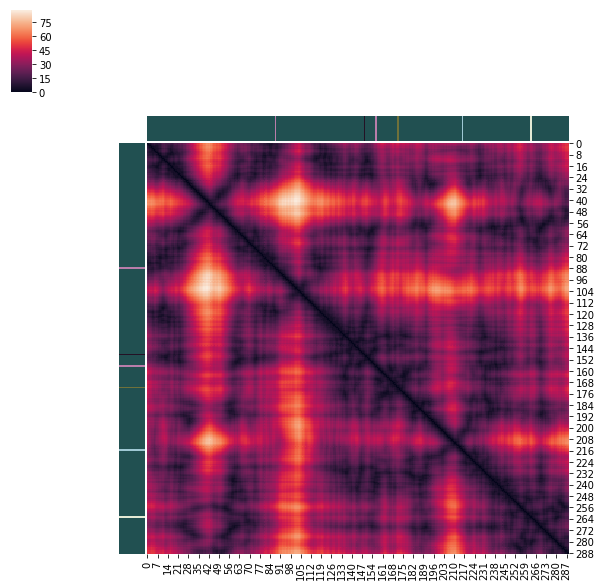

YP_009725298.1.B99990001.pdb
<class 'dict'>
{35: [27], 50: [301], 53: [39, 52, 139, 145, 217, 262, 475, 601], 57: [634], 58: [2, 23, 553], 59: [465, 602], 95: [272, 548, 577]}
[100 100  58 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100  58 100 100 100  35 100 100 100 100 100 100 100 100
 100 100 100  53 100 100 100 100 100 100 100 100 100 100 100 100  53 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100  53 100 100 100 100
 100  53 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 

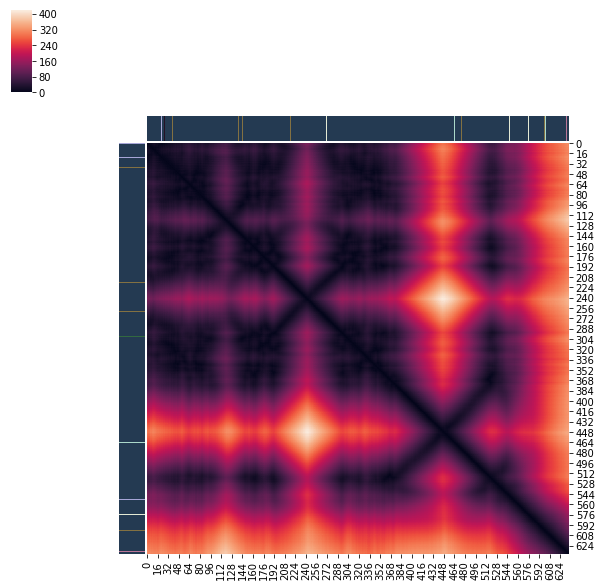

YP_009725305.1.B99990001.pdb
<class 'dict'>
{49: [83], 50: [3], 58: [74]}
[100 100 100  50 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100  58 100 100 100 100 100 100 100 100  49 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100]


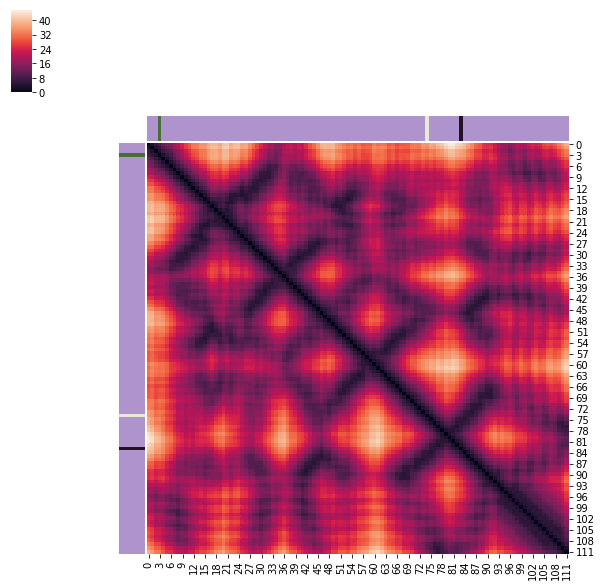

YP_009725301.1.B99990001.pdb
<class 'dict'>
{35: [258], 49: [111], 50: [160], 58: [282], 59: [93, 277]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100  59 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100  49 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  50 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100

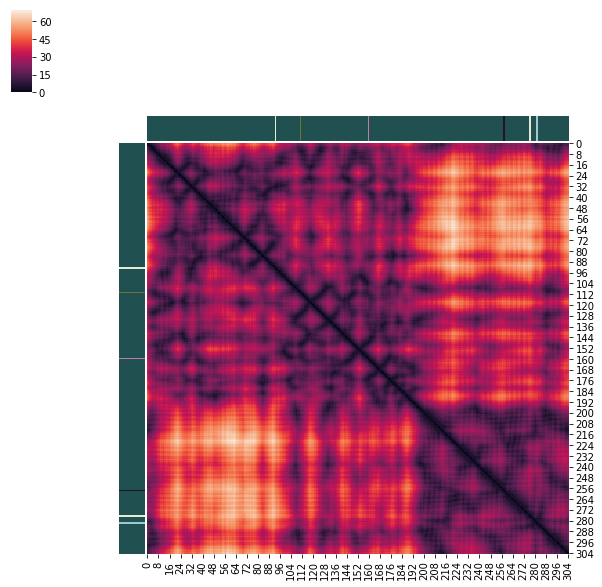

YP_009725309.1.B99990001.pdb
<class 'dict'>
{49: [193], 50: [27, 405], 53: [70, 432], 57: [153], 58: [92, 356], 59: [225, 291]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  50 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  53 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100  58 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  57 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100  49 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 

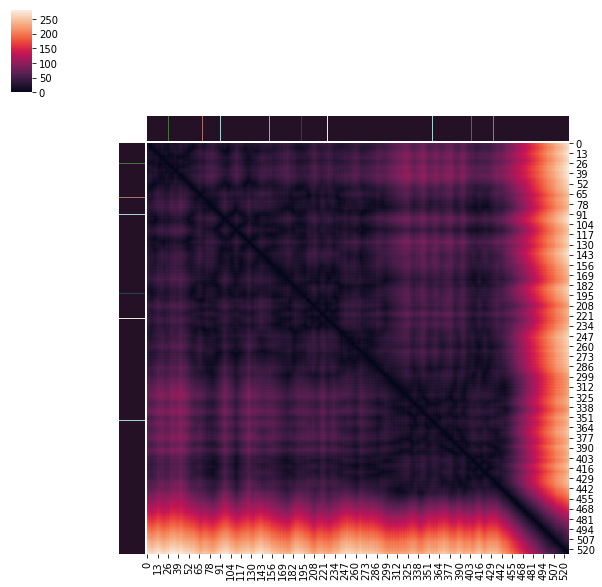

YP_009725300.1.B99990001.pdb
<class 'dict'>
{50: [233], 52: [434, 437], 53: [57, 198, 273, 419], 59: [382], 95: [297, 359]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100  53 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  53 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100


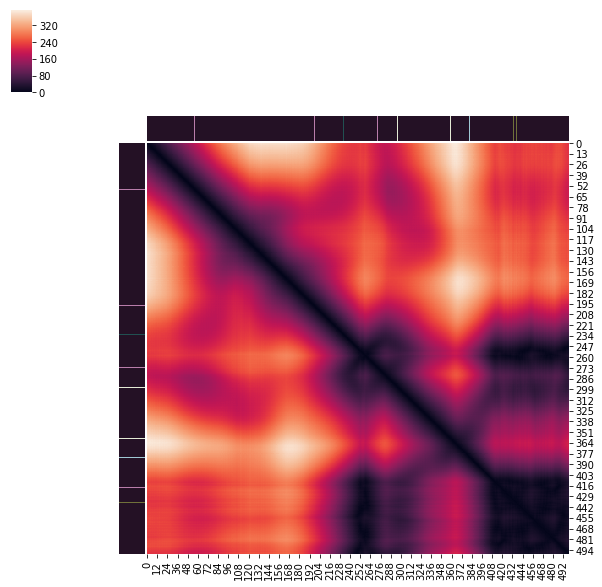

YP_009724397.2.B99990001.pdb
YP_009725299.1.B99990001.pdb
<class 'dict'>
{35: [1235, 1432, 1559], 49: [178, 179, 481, 811, 832, 969, 1021, 1322], 50: [20, 328, 986, 1382, 1715], 52: [432, 580, 1243, 1422], 53: [34, 55, 57, 96, 275, 308, 724, 726, 744, 775, 980, 1368, 1396, 1427, 1438], 57: [624, 814, 1313], 58: [193, 466, 1198, 1207, 1249, 1280, 1308, 1385, 1441], 59: [65, 109, 1275, 1289, 1307, 1418], 95: [823, 914]}
[100 100 100 ... 100 100 100]


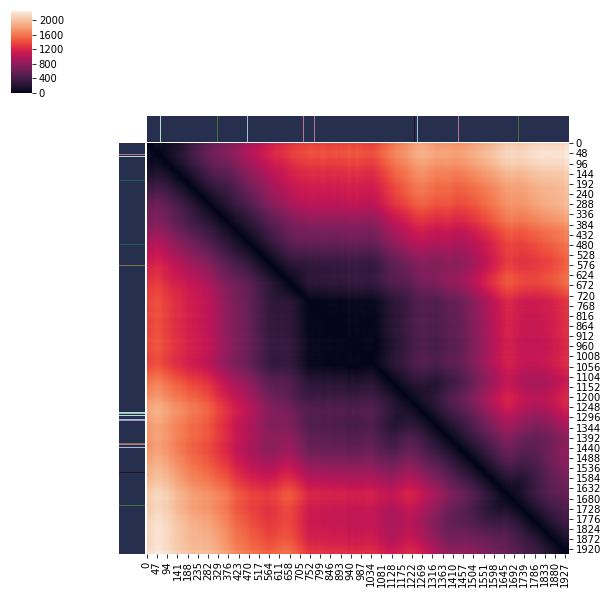

YP_009725304.1.B99990001.pdb
<class 'dict'>
{50: [16], 53: [158], 59: [134]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100  50 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100  59 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100  53 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100]


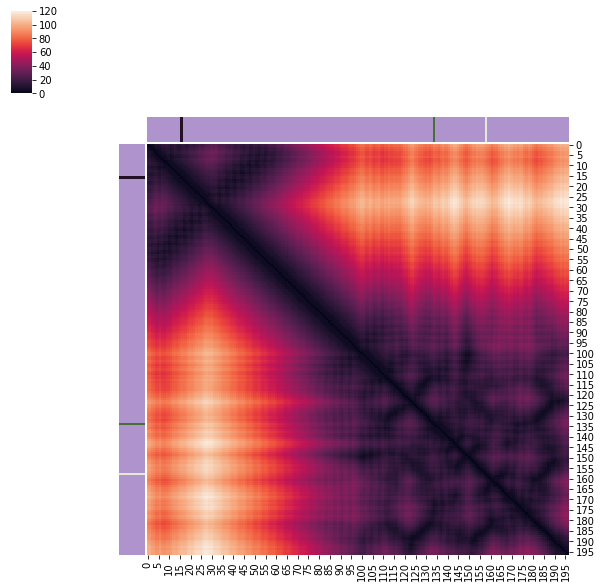

YP_009724390.1.B99990001.pdb
<class 'dict'>
{35: [25, 32, 183, 550, 848], 49: [148, 625, 1166], 50: [30, 486, 768], 52: [245, 1030], 53: [81], 57: [87, 145, 1233, 1250], 58: [15, 130, 242, 449, 521, 794, 834], 95: [93, 312, 772]}
[100 100 100 ... 100 100 100]


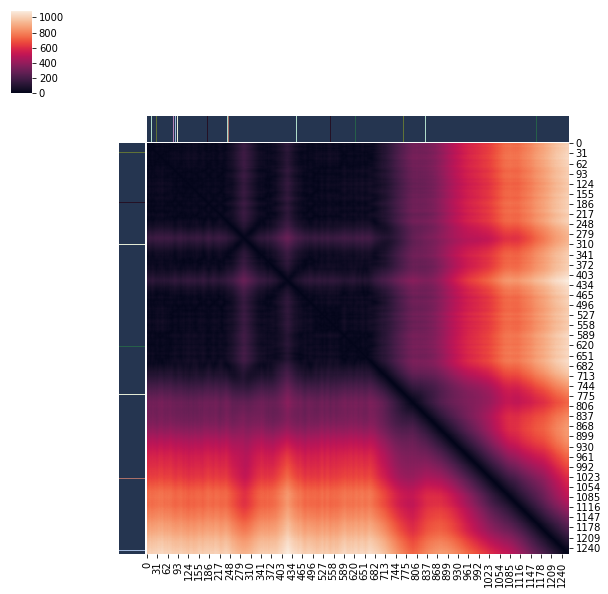

YP_009724394.1.B99990001.pdb
YP_009725318.1.B99990001.pdb
YP_009725310.1.B99990001.pdb
<class 'dict'>
{52: [156], 53: [9, 248], 58: [81, 181], 59: [26], 95: [147, 217]}
[100 100 100 100 100 100 100 100 100  53 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100  59 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  58 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100  95 100 100 100 100 100 100 100 100  52 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100  58 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100

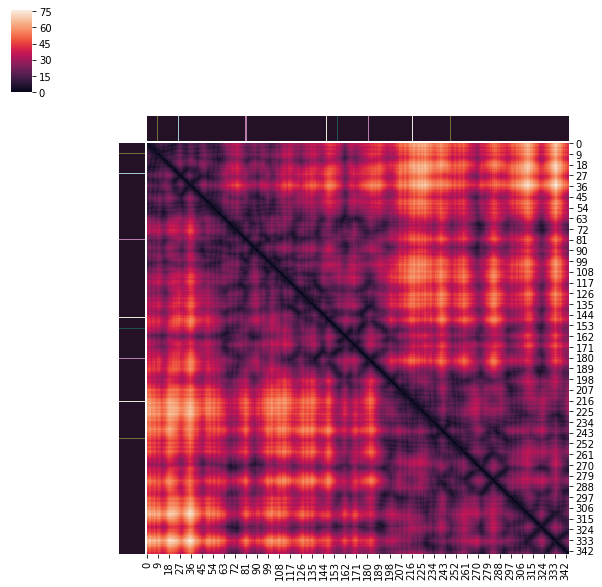

YP_009725303.1.B99990001.pdb
<class 'dict'>
{50: [67], 57: [65], 95: [30]}
[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100  95 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100  57 100  50 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100]


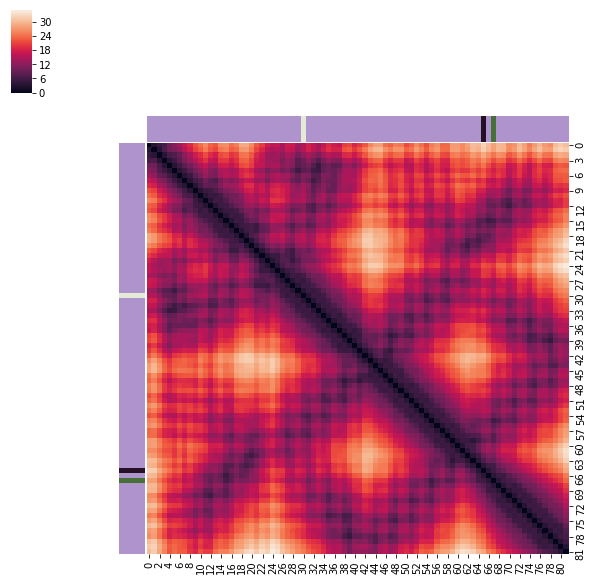

YP_009724396.1.B99990001.pdb


In [19]:
#use the 

from Bio.PDB.PDBParser import PDBParser
parser = PDBParser()
import json 
import seaborn as sns

for m in models:
    print(m)
    structure = parser.get_structure("test", m)
    model = structure[0]
    for chain in model.get_chains():
        distmat = np.array([ [ np.linalg.norm( r1["CA"].get_coord() - r2["CA"].get_coord() ) if i < j else 0 for i,r1 in enumerate(chain)] for j,r2 in enumerate(chain)] )   
        distmat+=distmat.T
        annotations = None
        
        for i,r in cannotation.iterrows():
            
            if r.sseqid in m:
                try:
                    annotations = dict( r.clusters  )

                    print(type(annotations))
                    # white or cluster color
                except:
                    pass
                break
                
        if annotations:     
            #go over all positions 
            print(annotations)
            colorvec = np.ones((distmat.shape[0]+1,) , dtype = np.int) *100
            count = 1
            for l in annotations:
                colorvec[annotations[l]]= l
            print(colorvec)
            colorvec = list(colorvec.ravel())
            network_pal = sns.cubehelix_palette( len(set(colorvec)) , light=.9, dark=.1, reverse=True, start=1, rot=-2) 
            network_lut = dict(zip(set(colorvec), network_pal))
            colorvec = [ network_lut[c] for c in colorvec ]
            g = sns.clustermap( distmat ,  row_cluster=False, col_cluster=False,row_colors=colorvec, col_colors=colorvec, linewidths=0 )



            plt.show()
            


In [87]:
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')

crange = [ c.get_hex_l() for c in red.range_to(blue, len(np.unique(cluster_labelsb))) ]
print(crange)

NameError: name 'cluster_labelsb' is not defined